<img src="img/logo-pirelli-dsa.png" align="left"/>
<br>

# Projeção de Produção - Pirelli
***
**Integrantes Grupo:**
<br>Danillo Silva
<br>Diego Dantas
<br>Gustavo Sainatto
<br>Nestor Soken
<br>Rubia Quinteiro Nierotka

## Bibliotecas:
***

In [1]:
#Lista de Packages Utilizados:

import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from sklearn import metrics

from math import sqrt
from math import pi

from pmdarima.arima import auto_arima

from connection import *
from getShift import *

%matplotlib inline

start_time = pd.Timestamp.today()

### Extração de Dados
***

In [2]:
#Criacao de Variaveis - Periodos de Tempos:

turnos = 3 #n de turnos a ser observado como amostra treino
tempo_turno = 8 * 60

turno_atual = pd.to_datetime(inicio_turno()) #funcao para o começo do turno desse momento
turno_passado = turno_atual - dt.timedelta(minutes=(tempo_turno * turnos))

turno_futuro = turno_atual + dt.timedelta(minutes=tempo_turno)

print('Turno Passado: {}'.format(turno_passado))
print('Turno Atual: {}'.format(turno_atual))
print('Turno Futuro: {}'.format(turno_futuro))

Turno Passado: 2019-05-10 07:00:00
Turno Atual: 2019-05-11 07:00:00
Turno Futuro: 2019-05-11 15:00:00


In [3]:
#Query Dataset:

query = open('queries/01_production.sql','r')

df_results = run_queryFS(query.read().format(turno_passado,turno_atual))

### Principais Características do Dataset:
***

In [4]:
#Analise - Dataset Dados Históricos:

print('Dataset Dados Historicos\nObservacoes(Linhas): {}\nVariaveis(Colunas): {}\n'.format(df_results.shape[0],df_results.shape[1]))
print('Principais Variaveis do Dataset: \n')
df_results.info()

df_results.head()

Dataset Dados Historicos
Observacoes(Linhas): 20447
Variaveis(Colunas): 5

Principais Variaveis do Dataset: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20447 entries, 0 to 20446
Data columns (total 5 columns):
MCH_NUMBER      20447 non-null object
EVS_START       20447 non-null datetime64[ns]
EVS_END         20447 non-null datetime64[ns]
MAT_SAP_CODE    12711 non-null object
EVS_REAL_QTY    20447 non-null float64
dtypes: datetime64[ns](2), float64(1), object(2)
memory usage: 798.8+ KB


,MCH_NUMBER,EVS_START,EVS_END,MAT_SAP_CODE,EVS_REAL_QTY
0,V12,2019-05-10 07:00:31,2019-05-10 07:01:35,None,1.0
1,V08,2019-05-10 07:00:36,2019-05-10 07:01:53,None,1.0
2,V03,2019-05-10 07:00:01,2019-05-10 07:02:01,None,1.0
3,V10,2019-05-10 07:00:31,2019-05-10 07:02:08,None,1.0
4,V07,2019-05-10 07:00:50,2019-05-10 07:02:13,None,1.0


### Transformar o Dataset em Series Temporais - Maquinas:
***

In [5]:
#Subset Dataset:

df_series = df_results[['EVS_END', 'MCH_NUMBER', 'EVS_REAL_QTY']]
df_series = df_series.groupby(by=['MCH_NUMBER', pd.Grouper(key='EVS_END', freq='5Min')]).sum()

df_series = df_series.unstack('MCH_NUMBER')
df_series.fillna(value=0, inplace=True)

df_series.columns = df_series.columns.droplevel()

df_series.info()
df_series.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 2019-05-10 07:00:00 to 2019-05-11 06:55:00
Freq: 5T
Data columns (total 20 columns):
AM1    288 non-null float64
AM2    288 non-null float64
AM3    288 non-null float64
AM4    288 non-null float64
TL1    288 non-null float64
TL2    288 non-null float64
TR1    288 non-null float64
TR2    288 non-null float64
V01    288 non-null float64
V02    288 non-null float64
V03    288 non-null float64
V04    288 non-null float64
V05    288 non-null float64
V06    288 non-null float64
V07    288 non-null float64
V08    288 non-null float64
V09    288 non-null float64
V10    288 non-null float64
V11    288 non-null float64
V12    288 non-null float64
dtypes: float64(20)
memory usage: 47.2 KB


MCH_NUMBER,AM1,AM2,AM3,AM4,TL1,TL2,TR1,TR2,V01,V02,V03,V04,V05,V06,V07,V08,V09,V10,V11,V12
EVS_END,,,,,,,,,,,,,,,,,,,,
2019-05-10 07:00:00,2.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,2.0,0.0,0.0,4.0,4.0,0.0,4.0,0.0,6.0
2019-05-10 07:05:00,2.0,3.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6.0,4.0,6.0,4.0,2.0,6.0,8.0,0.0,8.0,0.0,2.0
2019-05-10 07:10:00,3.0,3.0,2.0,5.0,0.0,0.0,2.0,1.0,6.0,8.0,6.0,4.0,2.0,4.0,8.0,8.0,0.0,2.0,0.0,4.0
2019-05-10 07:15:00,1.0,6.0,3.0,5.0,0.0,2.0,2.0,1.0,6.0,6.0,8.0,4.0,2.0,6.0,6.0,8.0,0.0,6.0,4.0,6.0
2019-05-10 07:20:00,3.0,4.0,2.0,4.0,2.0,4.0,1.0,2.0,6.0,8.0,8.0,4.0,0.0,2.0,6.0,6.0,0.0,6.0,6.0,4.0


C:\Users\silvada010\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


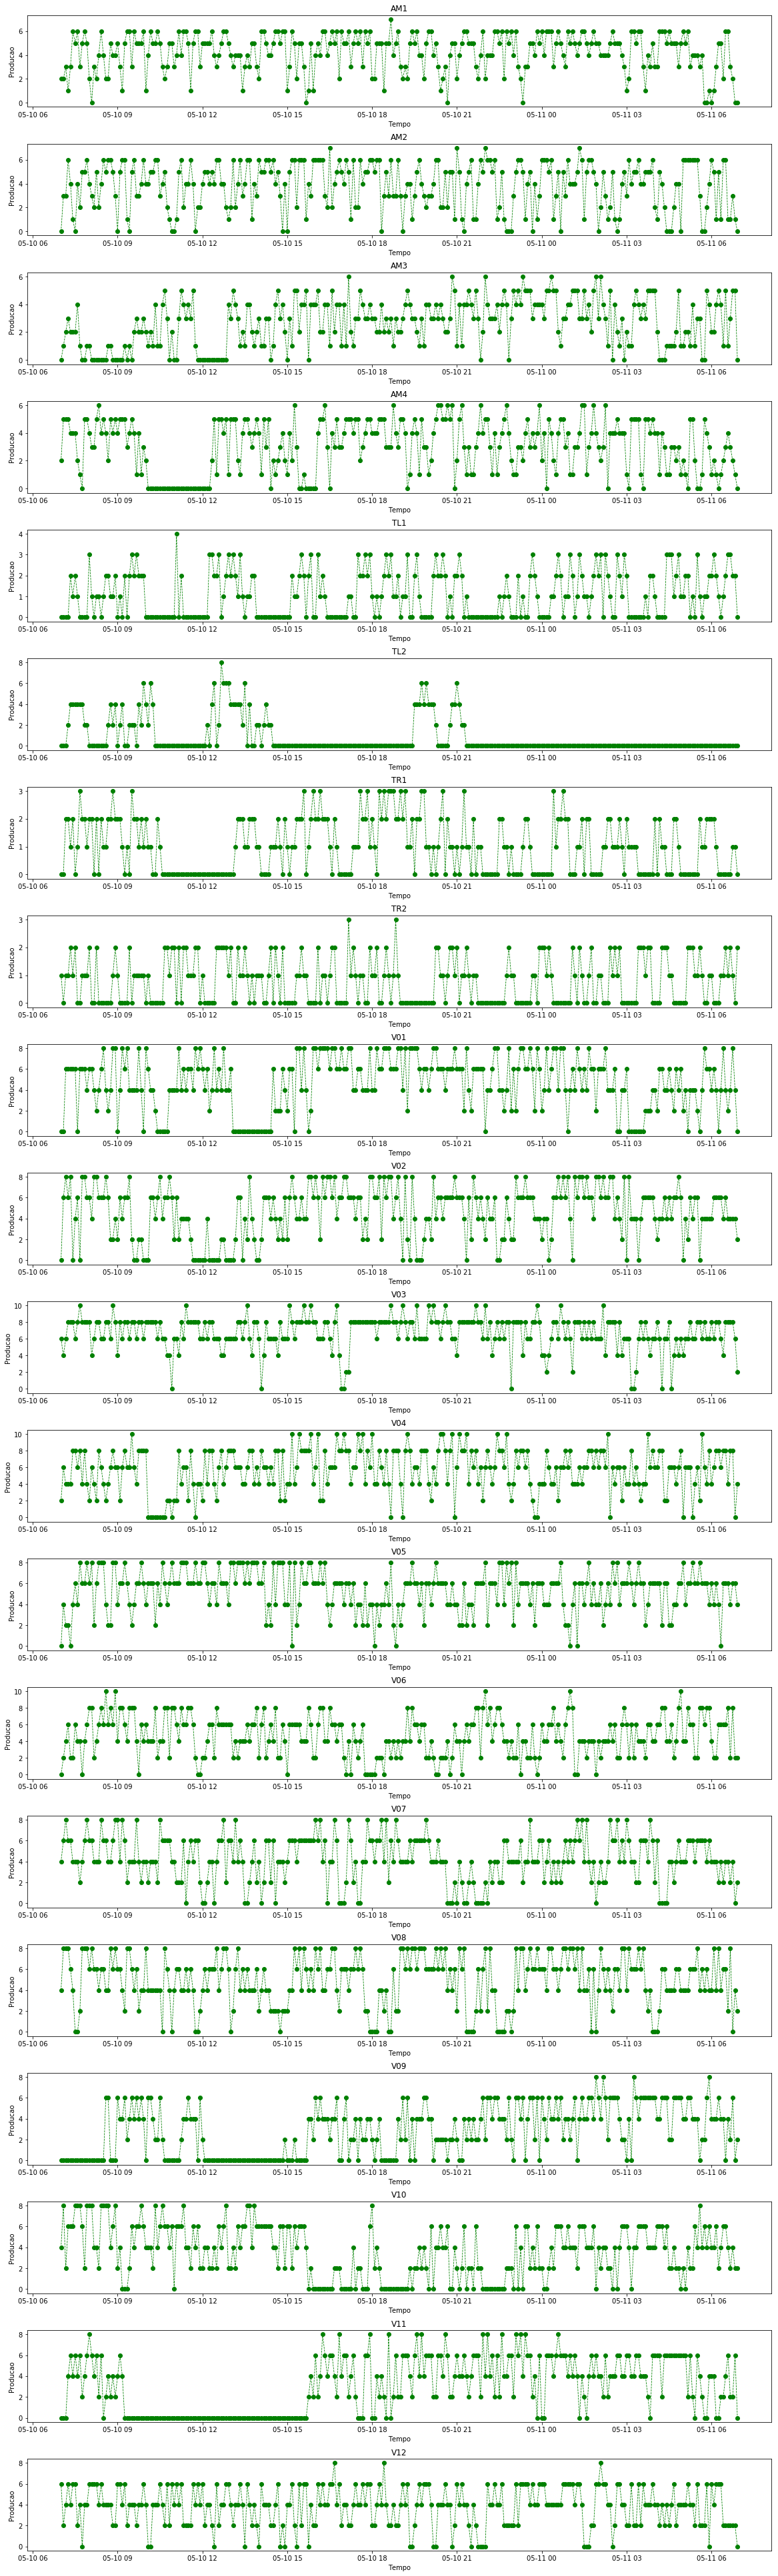

In [6]:
#Plot Series por Máquina:

fig, ax = plt.subplots(nrows=df_series.columns.size,ncols=1, figsize=(20,70))
fig.subplots_adjust(hspace =.4, wspace=.4)

for i in range(df_series.columns.size):
    ax[i].plot(df_series.index, df_series[df_series.columns[i]], color='green', marker='o', linestyle='dashed', linewidth = 0.8)
    
    ax[i].set_title(str(df_series.columns[i]))
    ax[i].set_xlabel('Tempo')
    ax[i].set_ylabel('Producao')

### Verificar Estacionaridade da Serie Temporal
***

In [7]:
#Testar Estacionaridade da Série Temporal através do Test Augmented Dickey-Fuller Test (ADF):

adf = dict(zip(df_series.columns.tolist(),
               [True if (adfuller(df_series[col])[1] < 0.05) else False for col in df_series.columns.tolist()]))
print(adf)

{'AM1': True, 'AM2': True, 'AM3': True, 'AM4': True, 'TL1': True, 'TL2': True, 'TR1': True, 'TR2': True, 'V01': True, 'V02': True, 'V03': True, 'V04': True, 'V05': True, 'V06': True, 'V07': True, 'V08': True, 'V09': True, 'V10': True, 'V11': False, 'V12': True}


### Calcular AUTO ARIMA para cada o Dataset Treino de cada Máquina:
***

In [8]:
#Criar um Dataset com os resultados do Treinamento para o Periodo Treino:

model ={}
for i in range(df_series.columns.size):
    maq = df_series.columns[i]
    print(str(maq) + ' - Modelo AUTO ARIMA:')
    
    arima_model = auto_arima(df_series[maq], seasonal=True, stationary=adf[maq],trace=True,
                             error_action='ignore',suppress_warnings=True, stepwise=True)
    
    score = np.array(arima_model.predict_in_sample())
    true = np.array(df_series[maq].values)
    
    score_tot = float(score.sum())
    true_tot = float(true.sum())
    
    acc = round((100 - abs((score_tot / true_tot)-1)*100) , 3)
    
    rmse = sqrt(metrics.mean_squared_error(true,score))
            
    model[maq] = [arima_model, score, true, acc, rmse]

df_model =  pd.DataFrame.from_dict(model, orient='index', columns=['model','score','true', 'acc','rmse'])

AM1 - Modelo AUTO ARIMA:
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=1076.062, BIC=1098.040, Fit time=0.233 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=1105.810, BIC=1113.136, Fit time=0.009 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=1070.510, BIC=1081.499, Fit time=0.033 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=1072.562, BIC=1083.551, Fit time=0.032 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=1072.085, BIC=1086.737, Fit time=0.074 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=1072.062, BIC=1086.714, Fit time=0.076 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=1074.062, BIC=1092.377, Fit time=0.229 seconds
Total fit time: 0.689 seconds
AM2 - Modelo AUTO ARIMA:
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=1211.361, BIC=1233.339, Fit time=0.159 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=1227

Fit ARIMA: order=(3, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=1295.901, BIC=1321.542, Fit time=0.221 seconds
Fit ARIMA: order=(3, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=1293.918, BIC=1315.896, Fit time=0.177 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=1316.811, BIC=1331.463, Fit time=0.076 seconds
Fit ARIMA: order=(4, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=1297.893, BIC=1327.196, Fit time=0.164 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=1299.413, BIC=1317.728, Fit time=0.168 seconds
Fit ARIMA: order=(4, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=1295.899, BIC=1321.540, Fit time=0.257 seconds
Fit ARIMA: order=(3, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=1299.247, BIC=1317.562, Fit time=0.087 seconds
Total fit time: 1.533 seconds
V02 - Modelo AUTO ARIMA:
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=1362.151, BIC=1369.477, Fit time=0.007 se

Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=1242.594, BIC=1264.571, Fit time=0.139 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=1355.422, BIC=1362.748, Fit time=0.007 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=1277.046, BIC=1288.035, Fit time=0.026 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=1312.121, BIC=1323.110, Fit time=0.040 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=1242.057, BIC=1260.372, Fit time=0.097 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=1241.801, BIC=1256.453, Fit time=0.095 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=1240.736, BIC=1259.050, Fit time=0.097 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=1240.808, BIC=1255.460, Fit time=0.057 seconds
Fit ARIMA: order=(3, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 0, 1) seasonal_order=(0, 0, 

In [9]:
#Mostrar Tabela de Resultados do Modelo:

df_model

,model,score,true,acc,rmse
AM1,"ARIMA(callback=None, disp=0, maxiter=None, met...","[4.22042468207296, 3.436119186638396, 3.436119...","[2.0, 2.0, 3.0, 1.0, 3.0, 6.0, 5.0, 6.0, 3.0, ...",99.936,1.536320
AM2,"ARIMA(callback=None, disp=0, maxiter=None, met...","[3.8022246133918665, 2.7761531169250535, 3.867...","[0.0, 3.0, 3.0, 6.0, 4.0, 1.0, 0.0, 4.0, 2.0, ...",99.930,1.942182
AM3,"ARIMA(callback=None, disp=0, maxiter=None, met...","[2.49263639669168, 1.402080007270622, 1.580116...","[0.0, 1.0, 2.0, 3.0, 2.0, 2.0, 2.0, 4.0, 1.0, ...",98.461,1.514404
AM4,"ARIMA(callback=None, disp=0, maxiter=None, met...","[2.9567683425638687, 2.4867052321032235, 3.797...","[2.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 2.0, 1.0, ...",99.803,1.629442
TL1,"ARIMA(callback=None, disp=0, maxiter=None, met...","[1.0401921564377319, 0.6178370073012802, 0.617...","[0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 2.0, 1.0, 0.0, ...",99.859,1.016855
TL2,"ARIMA(callback=None, disp=0, maxiter=None, met...","[0.7779432435780861, 0.2183970263556136, 0.159...","[0.0, 0.0, 0.0, 2.0, 4.0, 4.0, 4.0, 4.0, 4.0, ...",99.354,1.077624
TR1,"ARIMA(callback=None, disp=0, maxiter=None, met...","[0.9777940634283546, 0.5021775407465797, 0.386...","[0.0, 0.0, 2.0, 2.0, 1.0, 2.0, 0.0, 1.0, 3.0, ...",99.674,0.836919
TR2,"ARIMA(callback=None, disp=0, maxiter=None, met...","[0.7660220550334786, 0.8351895009647934, 0.539...","[1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 0.0, ...",99.969,0.788034
V01,"ARIMA(callback=None, disp=0, maxiter=None, met...","[4.529508433596004, 2.5558813319899207, 2.2798...","[0.0, 0.0, 6.0, 6.0, 6.0, 6.0, 6.0, 0.0, 6.0, ...",99.547,2.244108
V02,"ARIMA(callback=None, disp=0, maxiter=None, met...","[4.51116476970469, 2.8364934607828642, 4.02099...","[0.0, 6.0, 8.0, 6.0, 8.0, 0.0, 4.0, 6.0, 0.0, ...",99.833,2.298789


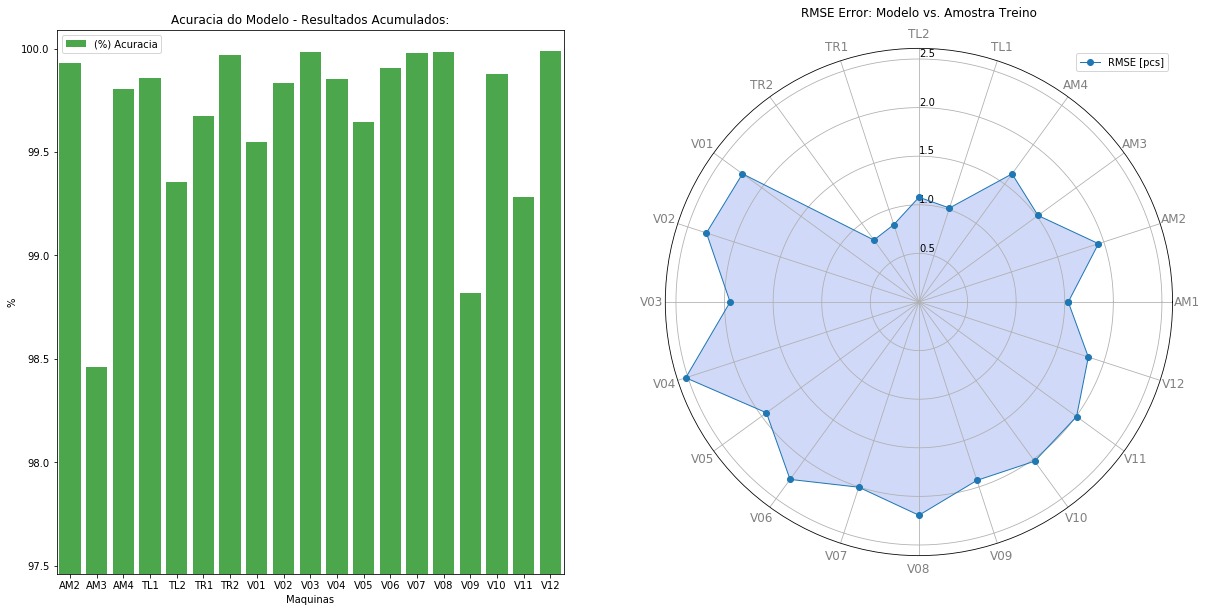

In [10]:
#Plot Gráficos de Resultados e RMSE - Período Acumulado:

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,10))
fig.subplots_adjust(hspace =.2, wspace=.2)

#Grafico Acuracia:

_= ax[0].bar(df_model.index, df_model['acc'],linewidth=.8, alpha = 0.7, color='green')

_= ax[0].set_ylim((df_model['acc'].min()-1),(df_model['acc'].max()+0.1))
_= ax[0].set_xlim(0.5,df_model.index.size-0.5)

_= ax[0].set_title('Acuracia do Modelo - Resultados Acumulados:')
_= ax[0].set_xlabel('Maquinas')
_= ax[0].set_ylabel('%')
_= ax[0].legend(['(%) Acuracia'],loc='best')


#Grafico RMSE:

angles = [n / float(df_model.index.size) * 2 * pi for n in range(df_model.index.size)]
angles += angles[:1]

values= values = list(df_model['rmse'])
values += values[:1]

ax = plt.subplot(122, polar=True)
_= plt.xticks(angles[:-1], df_model.index.tolist(), color='grey', size=12)

_= ax.set_rlabel_position(90)

_= ax.plot(angles, values, linewidth=1, marker='o', linestyle='solid', label='RMSE [pcs]')
_= ax.fill(angles, values, 'b', alpha=0.1)

_= ax.fill(angles, values, alpha=0.1)

_= ax.set_title('RMSE Error: Modelo vs. Amostra Treino')
_= ax.legend(loc='best')

### Projetar Periodo Futuro com Dados do Modelo por Máquina
***

In [11]:
#Criar Projecoes por Máquina:

intervalo = pd.date_range(start= turno_atual, end= turno_futuro, freq='5Min')

pred = {}
for i in range(df_model.shape[0]):
    pred[df_model.index[i]] = df_model['model'][i].predict(n_periods=intervalo.size)

df_forecast =  pd.DataFrame.from_dict(pred)
df_forecast.index = intervalo

df_forecast.info()

df_forecast.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97 entries, 2019-05-11 07:00:00 to 2019-05-11 15:00:00
Freq: 5T
Data columns (total 20 columns):
AM1    97 non-null float64
AM2    97 non-null float64
AM3    97 non-null float64
AM4    97 non-null float64
TL1    97 non-null float64
TL2    97 non-null float64
TR1    97 non-null float64
TR2    97 non-null float64
V01    97 non-null float64
V02    97 non-null float64
V03    97 non-null float64
V04    97 non-null float64
V05    97 non-null float64
V06    97 non-null float64
V07    97 non-null float64
V08    97 non-null float64
V09    97 non-null float64
V10    97 non-null float64
V11    97 non-null float64
V12    97 non-null float64
dtypes: float64(20)
memory usage: 15.9 KB


,AM1,AM2,AM3,AM4,TL1,TL2,TR1,TR2,V01,V02,V03,V04,V05,V06,V07,V08,V09,V10,V11,V12
2019-05-11 07:00:00,2.729673,2.922292,2.077769,1.538589,0.617837,0.166469,0.650689,1.130805,3.615766,3.739456,5.199686,5.007788,5.140812,4.143352,2.677648,3.683307,2.479937,2.979662,2.677398,2.782035
2019-05-11 07:05:00,3.693857,3.802225,2.546017,2.058230,0.868701,0.245572,0.632323,0.873857,4.481800,3.855571,6.230244,5.130840,5.169576,4.461548,3.488503,3.993199,2.490829,2.301196,2.679535,3.235022
2019-05-11 07:10:00,4.034429,3.802225,2.649156,2.121851,0.970561,0.321810,0.752154,0.797900,3.741274,3.954214,6.562167,5.228708,5.193136,4.404401,3.959782,4.406139,2.501082,3.371811,2.681671,3.899808
2019-05-11 07:15:00,4.154727,3.802225,2.669524,2.180967,1.011919,0.428167,0.830420,0.775446,3.672186,4.038015,6.669074,5.306544,5.212432,4.357597,4.120910,4.623172,2.510734,2.616967,2.683808,4.156653
2019-05-11 07:20:00,4.197219,3.802225,2.671175,2.235897,1.028712,0.509725,0.881538,0.768808,3.926892,4.109207,6.703506,5.368449,5.228238,4.322496,4.175999,4.737241,2.519820,3.532439,2.685945,3.683822


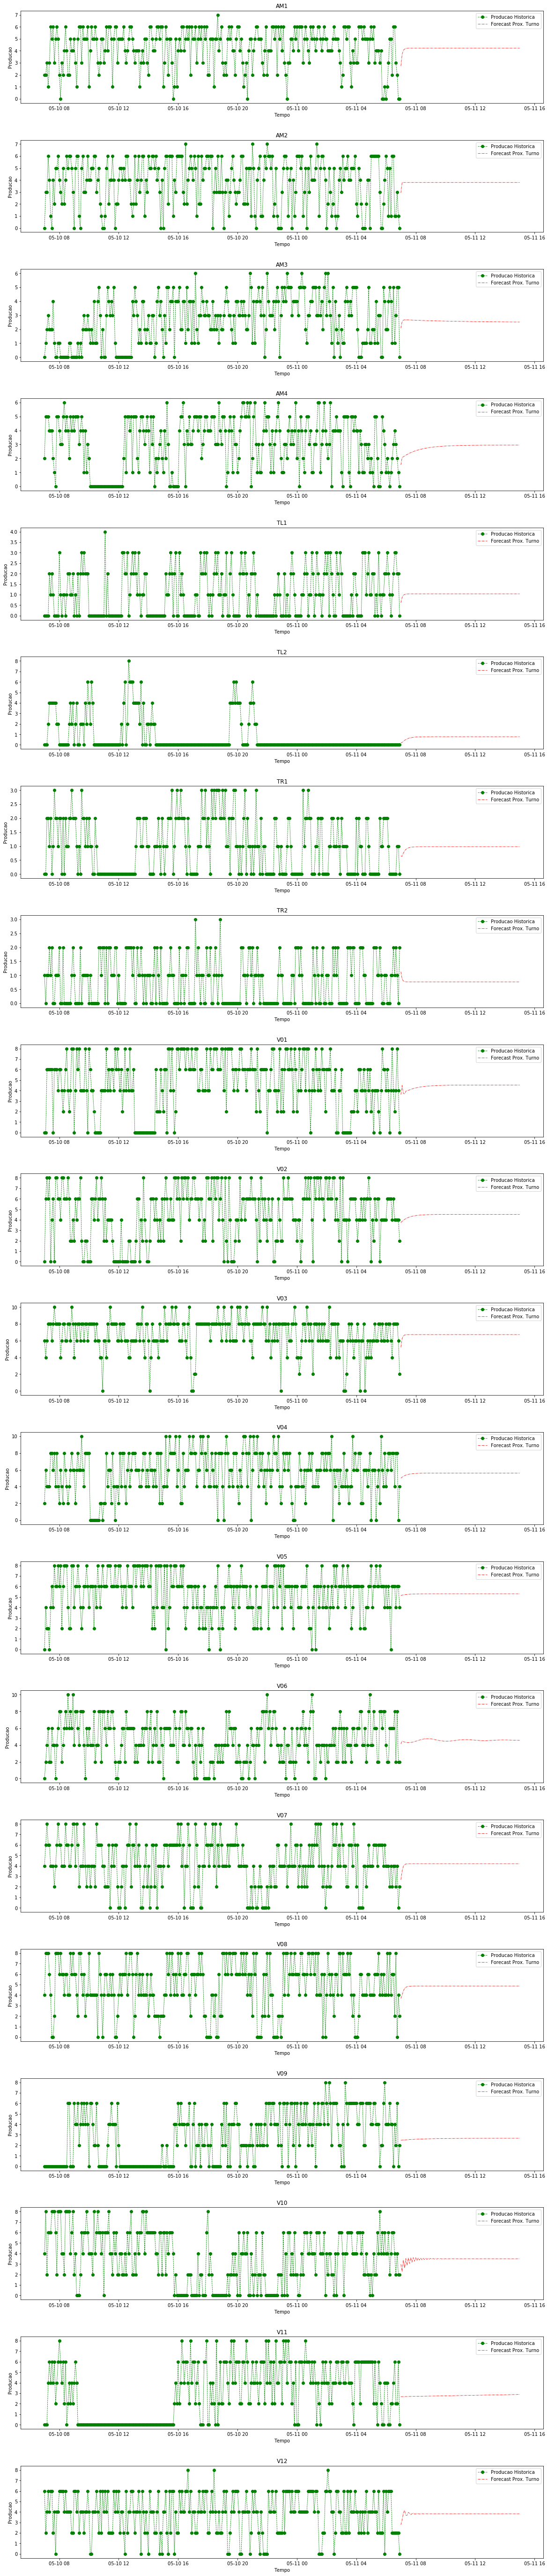

In [12]:
#Plot Graficos de Dataset Treino + Projecao:

fig, ax = plt.subplots(nrows=df_series.columns.size,ncols=1, figsize=(20,100))
fig.subplots_adjust(hspace =.4, wspace=.4)

for i in range(df_series.columns.size):
    ax[i].plot(df_series.index, df_series[df_series.columns[i]], color='green', marker='o', linestyle='dashed', linewidth = 0.8, label='Producao Historica')
    ax[i].plot(df_forecast.index,df_forecast[df_forecast.columns[i]], color='red', linestyle='dashdot', linewidth = 0.8, label='Forecast Prox. Turno')
    
    ax[i].set_title(str(df_series.columns[i]))
    ax[i].set_xlabel('Tempo')
    ax[i].set_ylabel('Producao')
    ax[i].legend(loc='best')
       

In [13]:
end_time = pd.Timestamp.today()

print("Executed in: {}".format(end_time - start_time))

Executed in: 0 days 00:01:04.562653
